In [1]:
%matplotlib inline
# %matplotlib notebook
import rasterio
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
import h5py
import pandas as pd
import numpy as np
import matplotlib
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def get_gaussian_kernel(fs_x, fs_y, sigma):
    """
    Create a 2D gaussian kernel
    :param fs_x: filter width along x axis
    :param fs_y: filter width along y axis
    :param sigma: gaussian width
    :return: 2D Gaussian filter of [fs_y x fs_x] dimension
    """
    gaussian_kernel_x = cv2.getGaussianKernel(ksize=np.int(fs_x), sigma=sigma)
    gaussian_kernel_y = cv2.getGaussianKernel(ksize=np.int(fs_y), sigma=sigma)
    gaussian_kernel = gaussian_kernel_y * gaussian_kernel_x.T
    return gaussian_kernel

In [3]:
def get_density_map_gaussian(points, d_map_h, d_map_w):
    """
    Creates density maps from ground truth point locations
    :param points: [x,y] x: along width, y: along height
    :param d_map_h: height of the density map
    :param d_map_w: width of the density map
    :return: density map
    """

    im_density = np.zeros(shape=(d_map_h,d_map_w), dtype=np.float32)

    if np.shape(points)[0] == 0:
        sys.exit()
    for i in range(np.shape(points)[0]):

        f_sz = 15
        sigma = 4

        gaussian_kernel = get_gaussian_kernel(f_sz, f_sz, sigma)

        x = min(d_map_w, max(1, np.abs(np.int32(np.floor(points[i][0])))))
        y = min(d_map_h, max(1, np.abs(np.int32(np.floor(points[i][1])))))

        if(x > d_map_w or y > d_map_h):
            continue

        x1 = x - np.int32(np.floor(f_sz / 2))
        y1 = y - np.int32(np.floor(f_sz / 2))
        x2 = x + np.int32(np.floor(f_sz / 2))
        y2 = y + np.int32(np.floor(f_sz / 2))

        dfx1 = 0
        dfy1 = 0
        dfx2 = 0
        dfy2 = 0

        change_H = False

        if(x1 < 1):
            dfx1 = np.abs(x1)+1
            x1 = 1
            change_H = True

        if(y1 < 1):
            dfy1 = np.abs(y1)+1
            y1 = 1
            change_H = True

        if(x2 > d_map_w):
            dfx2 = x2 - d_map_w
            x2 = d_map_w
            change_H = True

        if(y2 > d_map_h):
            dfy2 = y2 - d_map_h
            y2 = d_map_h
            change_H = True

        x1h = 1+dfx1
        y1h = 1+dfy1
        x2h = f_sz - dfx2
        y2h = f_sz - dfy2

        if (change_H == True):
            f_sz_y = np.double(y2h - y1h + 1)
            f_sz_x = np.double(x2h - x1h + 1)

            gaussian_kernel = get_gaussian_kernel(f_sz_x, f_sz_y, sigma)

        im_density[y1-1:y2,x1-1:x2] = im_density[y1-1:y2,x1-1:x2] +  gaussian_kernel
    return im_density

In [4]:
def get_coordenadas(raster,puntos,url_salida,nombre):
    pixeles = pd.DataFrame(columns=['x', 'y'])
    for index in range(puntos.shape[0]):
        pl = raster.index(puntos["geometry"][index].bounds[0],puntos["geometry"][index].bounds[1])
        pixeles.loc[index] = [pl[0],pl[1]]
    
    pixeles.to_csv(url_salida+"/"+nombre+".csv")
    return pixeles
        

In [5]:
# url_imagen = 'D:/Memoria/Codigo Memoria/CONTEO_SATELITE/imagenes/40050_pira_2017.tif'
# shp = 'D:/Memoria/Codigo Memoria/CONTEO_SATELITE/puntos_arboles/40050_pira_2017_arb.shp'
# url_salida = "D:/Memoria/Codigo Memoria/datos"

url_imagen = 'D:/Memoria/Codigo/AraucoNursery/PROYECTOS/VIVERO/imagenes/imagen_mesones_rgb.tif'
shp = 'D:/Memoria/Codigo/AraucoNursery/PROYECTOS/VIVERO/puntos_plantas/plantas_mesones_2.shp'
url_salida = "D:/Memoria/Codigo/AraucoNursery/train"
archivo_h5 = url_salida+'/data.h5' 

In [6]:
puntos = gpd.read_file(shp)
raster = rasterio.open(url_imagen)

In [7]:
coordenadas = []
csv = get_coordenadas(raster,puntos,url_salida,"pixeles")
# csv = pd.read_csv(url_salida+"/pixeles.csv")
for element in range(csv.shape[0]):
    coordenadas.append([csv["y"][element],csv["x"][element]])

In [8]:
mapa_densidad = get_density_map_gaussian(coordenadas,raster.height,raster.width)

In [10]:
mapa_densidad.tofile(url_salida+"/mapa_densidad.txt")

(1823, 2488)


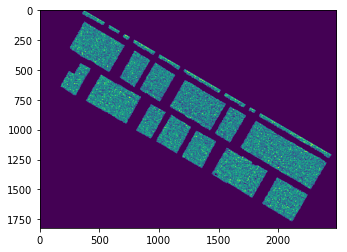

In [11]:
print(mapa_densidad.shape)
plt.imshow(mapa_densidad)
plt.show()

In [12]:
offsetX = 0
offsetY = 0
width = 100
height = 100
step = 10
nulo = [65535]
lista_imagenes = []
lista_etiquetas = []
contador = 0

In [13]:
%%time
contador = 0
while (1):
        # finalizar si se a recorrido toda la imagen
    if(offsetY >= raster.height and offsetX >= raster.width):
        
        break
     #cuando llegue al borde en el eje x, debo bajar(sumar en eje y) y debo volver a empezar setear offsetX en 0 y widthX en 100
    elif(offsetX >= raster.width):
        offsetY = offsetY + step
        offsetX = 0
        
    #entregamos los pixeles para obtener las coordenadas
    t = raster.xy(offsetX, offsetY)
    l = raster.xy(offsetX + width , offsetY)
    r = raster.xy(offsetX, offsetY + height)
    b = raster.xy(offsetX + width , offsetY + height)  
    bbox = box(l[0], b[1], r[0], t[1])
    #estoy cortando bien

    
    try:
        #transformacion de la imagen PNG
        out_img, out_transform = mask(raster, shapes=[bbox], crop=True)
        valores = np.unique(out_img)
#         print(out_transform)
        out_meta = raster.meta.copy()
        out_meta.update(  {"driver": "GTiff",
                   "height": 100,
                    "width": 100,
                    "transform": out_transform,
                    "crs": raster.crs})
        # si solo se tiene valores NODATA en la imagen, la descartamos
        if np.array_equal(valores,nulo):
            offsetX = offsetX + step
            continue
        # quitamos pixeles irrelevantes        
        out_png = out_img[0:3,1:101,0:100]
        out_img = out_img[:,1:101,0:100]
        
        out_meta.update(  {"driver": "GTiff",
                   "height": 100,
                    "width": 100,
                    "transform": out_transform,
                    "crs": raster.crs})
        
        #corte mapa densidad
        corte= mapa_densidad[offsetX: offsetX + width , offsetY : offsetY + height]
        
        lista_etiquetas.append(corte)
        lista_imagenes.append(out_png)
        
        
        matplotlib.image.imsave('{}/salida{}.png'.format(url_salida+"/png",contador), out_png.T)
     
        with rasterio.open('{}/salida{}.tif'.format(url_salida+"/tiff",contador), "w", **out_meta) as dest:
            dest.write(out_img)
  
#       interseccion ptos
#         interseccion = puntos["geometry"].intersects(bbox)
# #         puntos[interseccion]
#         print(puntos[interseccion])
#         cantidad = interseccion.value_counts()
#         if (True in cantidad.index):
#             numero = cantidad[True]
#         else:
#             numero = 0
#         print(numero)
    except ValueError:
        pass
#         print(url_salida+"/salida"+str(contador)+".tif")
#         print(coords)
    contador = contador + 1
    offsetX = offsetX + step 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Wall time: 7min 49s


In [14]:
n_lista_imagenes = len(lista_imagenes)
n_lista_etiquetas = len(lista_etiquetas)

lista_imagenes = np.array(lista_imagenes)
lista_etiquetas = np.array(lista_etiquetas)


HEIGHT = 100
WIDTH = 100


CHANNELS = 3
hf = h5py.File(archivo_h5, 'w')
# SHAPE = (HEIGHT, WIDTH, CHANNELS)

In [15]:
%%time
Xset = hf.create_dataset(
        name= "images",
        data=lista_imagenes,
        shape=(n_lista_imagenes,HEIGHT, WIDTH, CHANNELS),
        compression="gzip",
        compression_opts=9)

Wall time: 4min 22s


In [16]:
Yset = hf.create_dataset(
        name= "counts",
        data=lista_etiquetas,
        shape=(n_lista_etiquetas,HEIGHT,WIDTH),
        compression="gzip",
        compression_opts=9)

In [17]:
hf.close()

In [42]:
numero = 1499
with h5py.File(archivo_h5, 'r') as hf:
#     print(hf.keys())
#     a_group_key = list(hf.keys())
#     print(a_group_key)
#     print(type(hf["images"][0]),hf["images"][0].shape)
#     print(type(hf["counts"][0]),hf["counts"][0].shape)
    imagen = hf["images"][numero]
    densidad = hf["counts"][numero]

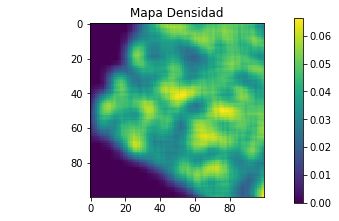

In [43]:
fig = plt.figure(figsize=(6, 3.2))
ax = fig.add_subplot(111)
ax.set_title('Mapa Densidad')
plt.imshow(densidad)
ax.set_aspect('equal')
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

(100, 100, 3)


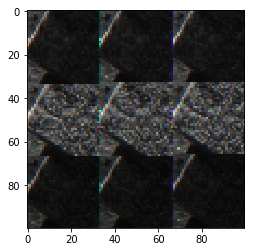

In [44]:
print(imagen.shape)
plt.imshow(imagen)
plt.show()

In [ ]:
# print(offsetX, offsetY,offsetX + width , offsetY + height)
# corte= mapa_densidad[offsetX: offsetX + width , offsetY : offsetY + height]
# print(corte.shape)

In [ ]:
# unique, counts = np.unique(corte, return_counts=True)
# dict(zip(unique, counts))